In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-06-10 14:32:22--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-06-10 14:32:22 (6.32 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [7]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [9]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      # careful, divereged from torch API
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3: # we want to compute mean and variane for all of batch not just consecutive groups
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, emb_dims):
    self.C = torch.randn((num_embeddings, emb_dims))
  def __call__(self, X):
    self.out = self.C[X]
    return self.out
  def parameters(self):
    return [self.C]

# -----------------------------------------------------------------------------------------------
class Flatten:
  def __call__(self, X):
    self.out = X.view(X.shape[0], -1)

    return self.out
  def parameters(self):
    return []
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, X):
    B, T, C = X.shape
    X = X.view(B, T//self.n, C*self.n) # instead of flattening group by n. for n=2, 32x8x10 --> 32x4x20 instead of 32x80
    if X.shape[1] == 1:
      X = X.squeeze(1)
    self.out = X
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers
  def __call__(self, X):
    for layer in self.layers:
      X = layer(X)
    self.out = X
    return self.out
  def parameters(self):
    parameters = [p for layer in self.layers for p in layer.parameters()]
    return parameters


In [10]:
torch.manual_seed(42); # seed rng for reproducibility

In [15]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=True),
])

with torch.no_grad():
  for layer in model.layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # not really needed after intriducing BatchNorm

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [16]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb = Xtr[ix]
print(Xb.shape)
print(Xb)
logits = model(Xb)

torch.Size([4, 8])
tensor([[ 0,  0, 19,  1, 25, 12,  1,  8],
        [ 0,  0,  0,  0,  0, 25, 22,  5],
        [ 0,  0,  0,  5, 13, 13,  1, 14],
        [ 0,  0,  0,  0,  0, 11, 25,  5]])


In [17]:
for layer in model.layers:
  print(layer.__class__.__name__, tuple(layer.out.shape))

Embedding (4, 8, 24)
FlattenConsecutive (4, 4, 48)
Linear (4, 4, 128)
BatchNorm1d (4, 4, 128)
Tanh (4, 4, 128)
FlattenConsecutive (4, 2, 256)
Linear (4, 2, 128)
BatchNorm1d (4, 2, 128)
Tanh (4, 2, 128)
FlattenConsecutive (4, 256)
Linear (4, 128)
BatchNorm1d (4, 128)
Tanh (4, 128)
Linear (4, 27)


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for layer in model.layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.4846
  10000/ 200000: 2.0871
  20000/ 200000: 1.9049
  30000/ 200000: 2.0226
  40000/ 200000: 1.8839
  50000/ 200000: 2.0713
  60000/ 200000: 1.8169
  70000/ 200000: 2.1594
  80000/ 200000: 1.4625
  90000/ 200000: 1.7484
 100000/ 200000: 1.7102
 110000/ 200000: 2.0091
 120000/ 200000: 1.6506
 130000/ 200000: 2.2323
 140000/ 200000: 1.8534
 150000/ 200000: 1.6495
 160000/ 200000: 1.4968
 170000/ 200000: 1.4502


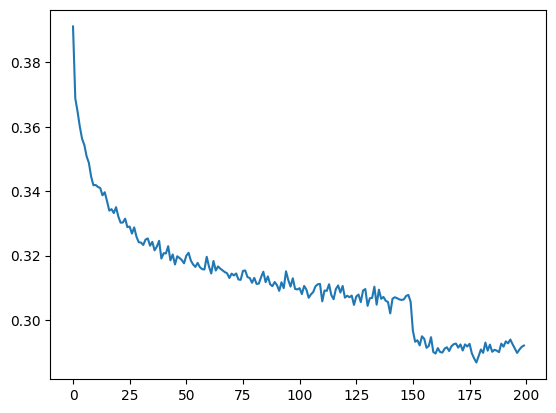

In [73]:
#torch.tensor(lossi[0:1000]).view(-1, 10).mean(1).shape
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [74]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.924579381942749
val 2.026484489440918


In [78]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

montalmya.
ziyel.
ndhona.
arethan.
ejgrace.
adelynne.
illemion.
aleke.
sustana.
septen.
hones.
noshub.
rishith.
ston.
jesten.
pantenco.
ubrey.
dariyah.
faels.
kayshus.


In [76]:
context.shape

AttributeError: 'list' object has no attribute 'shape'